## Import necessary libraries

In [11]:
import torch
from torch_geometric import datasets
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE

## Import necessary dataset

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [4]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.8980797636632203
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Building the Model

In [5]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [6]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9513
Epoch: 002, Loss: 1.9475
Epoch: 003, Loss: 1.9442
Epoch: 004, Loss: 1.9375
Epoch: 005, Loss: 1.9306
Epoch: 006, Loss: 1.9236
Epoch: 007, Loss: 1.9178
Epoch: 008, Loss: 1.9066
Epoch: 009, Loss: 1.8971
Epoch: 010, Loss: 1.8882
Epoch: 011, Loss: 1.8798
Epoch: 012, Loss: 1.8643
Epoch: 013, Loss: 1.8608
Epoch: 014, Loss: 1.8436
Epoch: 015, Loss: 1.8267
Epoch: 016, Loss: 1.8165
Epoch: 017, Loss: 1.7909
Epoch: 018, Loss: 1.7876
Epoch: 019, Loss: 1.7703
Epoch: 020, Loss: 1.7311
Epoch: 021, Loss: 1.7333
Epoch: 022, Loss: 1.7174
Epoch: 023, Loss: 1.7031
Epoch: 024, Loss: 1.6600
Epoch: 025, Loss: 1.6619
Epoch: 026, Loss: 1.6213
Epoch: 027, Loss: 1.6076
Epoch: 028, Loss: 1.5913
Epoch: 029, Loss: 1.5748
Epoch: 030, Loss: 1.5055
Epoch: 031, Loss: 1.4970
Epoch: 032, Loss: 1.4865
Epoch: 033, Loss: 1.4400
Epoch: 034, Loss: 1.4259
Epoch: 035, Loss: 1.3945
Epoch: 036, Loss: 1.3996
Epoch: 037, Loss: 1.3797
Epoch: 038, Loss: 1.3357
Epoch: 039, Loss: 1.2907
Epoch: 040, Loss: 1.2608


In [8]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5500


In [9]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


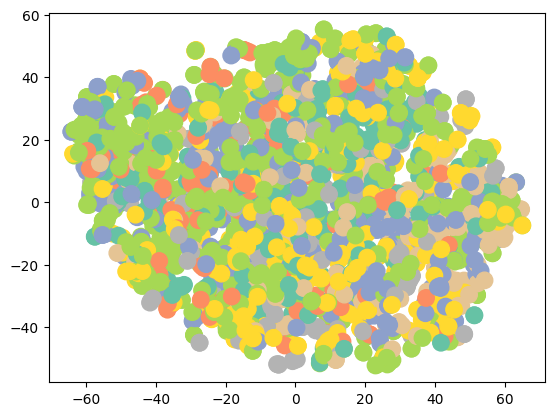

In [13]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
plt.scatter(z[:, 0], z[:, 1], s=140, c=data.y, cmap="Set2")

In [23]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 501):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [24]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


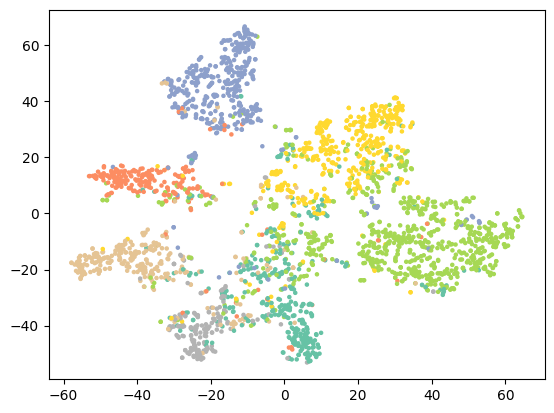

In [25]:
model.eval()

out = model(data.x, data.edge_index)

z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
plt.scatter(z[:, 0], z[:, 1], s=5, c=data.y, cmap="Set2")

### Using Validation Loss

In [21]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 500):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9469
Epoch: 002, Loss: 1.9366
Epoch: 003, Loss: 1.9270
Epoch: 004, Loss: 1.9148
Epoch: 005, Loss: 1.9035
Epoch: 006, Loss: 1.8930
Epoch: 007, Loss: 1.8804
Epoch: 008, Loss: 1.8648
Epoch: 009, Loss: 1.8529
Epoch: 010, Loss: 1.8414
Epoch: 011, Loss: 1.8263
Epoch: 012, Loss: 1.8153
Epoch: 013, Loss: 1.8057
Epoch: 014, Loss: 1.7868
Epoch: 015, Loss: 1.7734
Epoch: 016, Loss: 1.7666
Epoch: 017, Loss: 1.7504
Epoch: 018, Loss: 1.7510
Epoch: 019, Loss: 1.7319
Epoch: 020, Loss: 1.7186
Epoch: 021, Loss: 1.7153
Epoch: 022, Loss: 1.7177
Epoch: 023, Loss: 1.7040
Epoch: 024, Loss: 1.6958
Epoch: 025, Loss: 1.6837
Epoch: 026, Loss: 1.6731
Epoch: 027, Loss: 1.6626
Epoch: 028, Loss: 1.6440
Epoch: 029, Loss: 1.6434
Epoch: 030, Loss: 1.6334
Epoch: 031, Loss: 1.6287
Epoch: 032, Loss: 1.6088
Epoch: 033, Loss: 1.6079
Epoch: 034, Loss: 1.5887
Epoch: 035, Loss: 1.5879
Epoch: 036, Loss: 1.5739
Epoch: 037, Loss: 1.5571
Epoch: 038, Loss: 1.5346
Epoch: 039, Loss: 1.5280
Epoch: 040, Loss: 1.5152


In [22]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8390


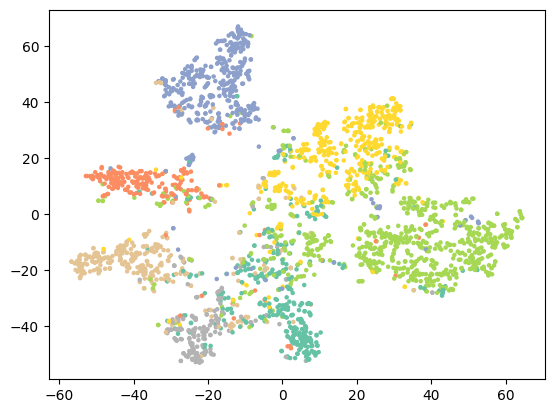

In [26]:
model.eval()

out = model(data.x, data.edge_index)

z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
plt.scatter(z[:, 0], z[:, 1], s=5, c=data.y, cmap="Set2")

### Set Hidden Channels to 32 and 64 will it work?

In [28]:
import pandas as pd
df_accuracy = pd.DataFrame(columns = ['channel_size','accuracy'])

In [38]:
hidden_channels_list = [32,64]
accuracy_list = []
for channel_size in hidden_channels_list:

    model = GCN(hidden_channels=channel_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 500):
        loss = train()
        #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        
        
    test_acc = test()
    accuracy_list.append(test_acc)

In [40]:
acc_dic = {'channel_size':hidden_channels_list,'test_accuracy':accuracy_list}
acc_df = pd.DataFrame(acc_dic)
acc_df

,channel_size,test_accuracy
0,32,0.805
1,64,0.809


In [43]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GATConv(in_channels = dataset.num_features,out_channels=hidden_channels,heads=heads,concat=False)  # TODO
        self.conv2 = GATConv(in_channels=hidden_channels,out_channels=dataset.num_classes,heads=heads,concat=False)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(8, 7, heads=8)
)
Epoch: 001, Loss: 1.9460, Val: 0.1560, Test: 0.1440
Epoch: 002, Loss: 1.9459, Val: 0.1560, Test: 0.1440
Epoch: 003, Loss: 1.9458, Val: 0.2280, Test: 0.2750
Epoch: 004, Loss: 1.9456, Val: 0.3200, Test: 0.3210
Epoch: 005, Loss: 1.9453, Val: 0.3140, Test: 0.3190
Epoch: 006, Loss: 1.9451, Val: 0.3140, Test: 0.3210
Epoch: 007, Loss: 1.9450, Val: 0.4080, Test: 0.4030
Epoch: 008, Loss: 1.9448, Val: 0.2520, Test: 0.2410
Epoch: 009, Loss: 1.9446, Val: 0.3060, Test: 0.2880
Epoch: 010, Loss: 1.9447, Val: 0.2300, Test: 0.2250
Epoch: 011, Loss: 1.9445, Val: 0.2000, Test: 0.2010
Epoch: 012, Loss: 1.9442, Val: 0.2180, Test: 0.2160
Epoch: 013, Loss: 1.9442, Val: 0.3540, Test: 0.3500
Epoch: 014, Loss: 1.9444, Val: 0.2520, Test: 0.2740
Epoch: 015, Loss: 1.9440, Val: 0.1520, Test: 0.1810
Epoch: 016, Loss: 1.9441, Val: 0.3620, Test: 0.3840
Epoch: 017, Loss: 1.9436, Val: 0.4820, Test: 0.5190
Epoch: 018, Loss: 1.9432, Val: 0.5240,